### Descripción 

El objetivo de la actividad consiste en escoger una temática de películas a partir de la siguiente web de películas de la Internet Movie Database IMDB.

La temática puede se por ejemplo: “Selecciones Populares”, “Favoritas de los seguidores” …

Una vez escogida la temática, se trata que captures de forma dinámica, los siguientes datos de las 4 primeras películas que aparezcan en la web bajo la temática escogida.

Los datos a capturar de cada página son:

1. Puntuación (Rating) 
2. Duración 
3. Año 
4. Descripción  
5. Dirección (Director) 
6. Guión (Writers) 
7. Reparto principal (Stars) 
8. Géneros (p.e. Acción, Aventuras…)
9. Lista de películas en “Más del estilo” (“More like this”)
10. Una imagen de la película



In [3]:
# import libraries

from requests import get
from bs4 import BeautifulSoup
from time import time, sleep
from random import randint
from selenium import webdriver
from IPython.display import Image, display
from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter


import collections
import urllib
import json
import numpy as np 
import pandas as pd
import IPython


headers = {"Accept-Language": "en-US, en;q=0.5"}

## BS4

In [12]:
# Setup BS4 
url = "https://www.imdb.com/search/title/?title_type=feature&genres"
url_imdb = 'https://www.imdb.com'
response = get(url)

# BS4 
soup = BeautifulSoup(response.text, 'html.parser') # 'html.parser' indica que queremos realizar el análisis utilizando el html integrado de Python

# Peliculas IMDB
movie_containers = soup.find_all('div', class_ = 'lister-item mode-advanced')

In [13]:
# Almacenamos los valores extraídos
movies_dict = collections.defaultdict(dict)

# Inicializando el driver
browser = webdriver.Firefox()

# helpers
def get_related_movies(soup: BeautifulSoup, movie_class="ipc-poster-card ipc-poster-card--base ipc-poster-card--dynamic-width ipc-sub-grid-item ipc-sub-grid-item--span-2"):
    movies = soup.find_all('section', {"data-testid" : "MoreLikeThis"})
    related_movies = movies[0].find_all('div', class_=movie_class)
    
    return [related_movie.find_all('span', {"data-testid" : "title"})[0].text for related_movie in related_movies]
        
def get_related_writers(soup: BeautifulSoup, writer_class="ipc-inline-list ipc-inline-list--show-dividers ipc-inline-list--inline ipc-metadata-list-item__list-content base"):
    writers = soup.find_all('ul', class_=writer_class)
    related_writers = writers[2].find_all('a', class_ = "ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link")
    
    return [writer.text for writer in related_writers]

In [14]:
# Extracción bs4 

for i in range(4):
    container = movie_containers[i]
    if container.find('div',class_ = 'ratings-metascore'): 
        #Scrap name
        name = container.h3.a.text
        
        #Scrap years
        movies_dict[name]['Year'] = container.h3.find('span', class_ = 'lister-item-year').text
        
        #Scrap IMBD rating
        movies_dict[name]['IMBD rating'] = float(container.strong.text)
        
        #Scrap Metascore
        movies_dict[name]['Metascore rating'] = container.find('span', class_ ='metascore').getText().strip()
        
        #Scrap number of votes 
        movies_dict[name]['Votes'] = container.find('span', attrs = {'name':'nv'})['data-value']
        
        #Scrap the directors
        movies_dict[name]['Director'] = ''.join(container.find('p', class_ = '').text.split('Stars')[0].split('\n')[2:-2]).replace("|Stars:", "")
        
        #Scrap the Stars
        movies_dict[name]['Cast (Stars)'] = ''.join(container.find('p', class_ = '').text.split('Director')[1].split('\n')[4:-1]).replace("\n", "")
        
        #Scrap Genre
        movies_dict[name]['Genre'] = container.find('span', {'class': 'genre'}).getText().strip()
        
        #Scrap Runtime
        movies_dict[name]['Duration'] = container.find('span', {'class': 'runtime'}).getText()
        
        #Scrap synopsis
        movies_dict[name]['Synopsis'] = container.find_all("p", {"class":  "text-muted"})[1].getText().replace("\n", "")
        
        #Scrap image
        movies_dict[name]['Image_link'] = container.find("img", class_="loadlate")["loadlate"]
         
        link = container.a['href']
        browser.get(url_imdb + link)
        soup2 = BeautifulSoup(browser.page_source, "html.parser")
        
        #Scrap more like this
        movies_dict[name]['More like this'] = get_related_movies(soup2)[:4]
        
        #Scrap writers
        movies_dict[name]['Writers'] = get_related_writers(soup2)
        

In [15]:
#Generamos un diccionario de Python con los datos obtenidos (excepto la imagen) guarda en un fichero de texto los datos de los diccionarios obtenidos.
json_str = json.dumps(movies_dict, sort_keys=True, indent=4)
print(highlight(json_str, JsonLexer(), TerminalFormatter()))

{
    "Batman": {
        "Cast (Stars)": "Robert Pattinson, Zo\u00eb Kravitz, Jeffrey Wright, Colin Farrell",
        "Director": "Matt Reeves",
        "Duration": "176 min",
        "Genre": "Action, Crime, Drama",
        "IMBD rating": 8.3,
        "Image_link": "https://m.media-amazon.com/images/M/MV5BMDdmMTBiNTYtMDIzNi00NGVlLWIzMDYtZTk3MTQ3NGQxZGEwXkEyXkFqcGdeQXVyMzMwOTU5MDk@._V1_UX67_CR0,0,67,98_AL_.jpg",
        "Metascore rating": "72",
        "More like this": [
            "The Dark Knight",
            "Spider-Man: No Way Home",
            "Batman Begins",
            "The Dark Knight Rises"
        ],
        "Synopsis": "When the Riddler, a sadistic serial killer, begins murdering key political figures in Gotham, Batman is forced to investigate the city's hidden corruption and question his family's involvement.",
        "Votes": "306594",
        "Writers": [
            "Matt Reeves",
            "Peter Craig",
            "Bill Finger"
        ],
        "Year": "(2

Batman {'Year': '(2022)', 'IMBD rating': 8.3, 'Metascore rating': '72', 'Votes': '306594', 'Director': 'Matt Reeves', 'Cast (Stars)': 'Robert Pattinson, Zoë Kravitz, Jeffrey Wright, Colin Farrell', 'Genre': 'Action, Crime, Drama', 'Duration': '176 min', 'Synopsis': "When the Riddler, a sadistic serial killer, begins murdering key political figures in Gotham, Batman is forced to investigate the city's hidden corruption and question his family's involvement.", 'Image_link': 'https://m.media-amazon.com/images/M/MV5BMDdmMTBiNTYtMDIzNi00NGVlLWIzMDYtZTk3MTQ3NGQxZGEwXkEyXkFqcGdeQXVyMzMwOTU5MDk@._V1_UX67_CR0,0,67,98_AL_.jpg', 'More like this': ['The Dark Knight', 'Spider-Man: No Way Home', 'Batman Begins', 'The Dark Knight Rises'], 'Writers': ['Matt Reeves', 'Peter Craig', 'Bill Finger']}


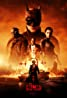

Deep Water {'Year': '(2022)', 'IMBD rating': 5.4, 'Metascore rating': '52', 'Votes': '25164', 'Director': 'Adrian Lyne', 'Cast (Stars)': 'Ben Affleck, Ana de Armas, Tracy Letts, Grace Jenkins', 'Genre': 'Drama, Mystery, Thriller', 'Duration': '115 min', 'Synopsis': 'A well-to-do husband who allows his wife to have affairs in order to avoid a divorce becomes a prime suspect in the disappearance of her lovers.', 'Image_link': 'https://m.media-amazon.com/images/M/MV5BNTE1M2NjNDgtYjQ2Ny00YTMzLWJiYWQtMTdmM2Q2YjA1MDg1XkEyXkFqcGdeQXVyODk4OTc3MTY@._V1_UX67_CR0,0,67,98_AL_.jpg', 'More like this': ['Windfall', 'Fresh', 'The Adam Project', 'Black Crab'], 'Writers': []}


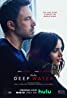

X {'Year': '(II) (2022)', 'IMBD rating': 7.3, 'Metascore rating': '79', 'Votes': '9703', 'Director': 'Ti West', 'Cast (Stars)': 'Mia Goth, Jenna Ortega, Brittany Snow, Kid Cudi', 'Genre': 'Horror', 'Duration': '105 min', 'Synopsis': 'In 1979, a group of young filmmakers set out to make an adult film in rural Texas, but when their reclusive, elderly hosts catch them in the act, the cast find themselves fighting for their lives.', 'Image_link': 'https://m.media-amazon.com/images/M/MV5BMTJiMmE5YWItOWZjYS00YTg0LWE0MTYtMzg2ZTY4YjNkNDEzXkEyXkFqcGdeQXVyMTAzMDg4NzU0._V1_UY98_CR5,0,67,98_AL_.jpg', 'More like this': ['The Outfit', 'Everything Everywhere All at Once', 'The Lost City', 'Fresh'], 'Writers': []}


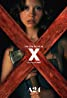

The Adam Project {'Year': '(2022)', 'IMBD rating': 6.7, 'Metascore rating': '55', 'Votes': '119424', 'Director': 'Shawn Levy', 'Cast (Stars)': 'Ryan Reynolds, Walker Scobell, Mark Ruffalo, Jennifer Garner', 'Genre': 'Action, Adventure, Comedy', 'Duration': '106 min', 'Synopsis': 'After accidentally crash-landing in 2022, time-traveling fighter pilot Adam Reed teams up with his 12-year-old self for a mission to save the future.', 'Image_link': 'https://m.media-amazon.com/images/M/MV5BOWM0YWMwMDQtMjE5NS00ZTIwLWE1NWEtODViMWZjMWI2OTU3XkEyXkFqcGdeQXVyMTEyMjM2NDc2._V1_UX67_CR0,0,67,98_AL_.jpg', 'More like this': ['Free Guy', "The Hitman's Bodyguard: Dangerous Women", 'Spider-Man: No Way Home', 'Red Notice'], 'Writers': []}


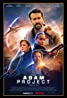

In [16]:
#Presentamos en el output del notebook, los datos de cada diccionario obtenido junto a la imagen de cada película.
for key, value in movies_dict.items():
    print(key, value)
    display(Image(value['Image_link']))
    